In [1067]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [1068]:
## Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

In [1069]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode", "TransactionGroup"])
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-972.619715
2013-12-30,-75.956876
2013-12-30,127.430470
2013-12-30,-38.300469
2013-12-30,-117.467137
...,...
2020-12-31,-19.288367
2020-12-31,-832.837608
2020-12-31,-103.691425


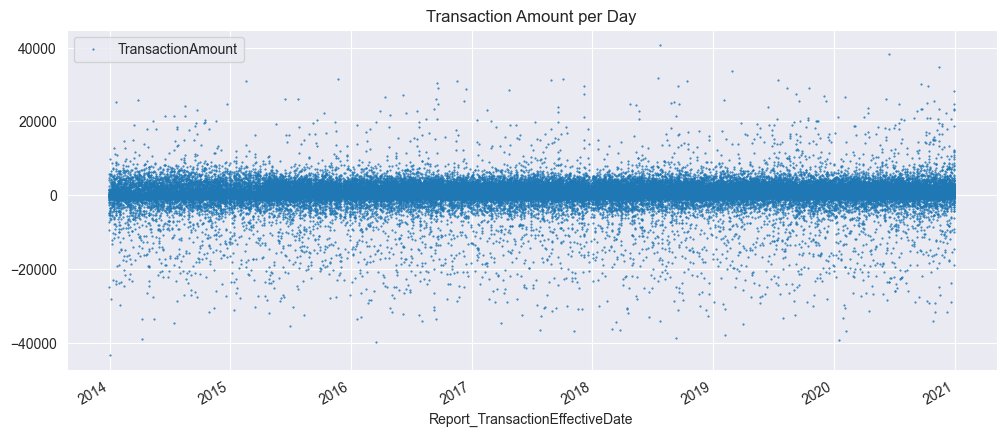

In [1070]:
## Each Transaction Value
colour_pal = sns.color_palette()
df.plot(style='.', ms=1, figsize=(12, 5), color=colour_pal[0], title="Transaction Amount per Day" )
plt.show()

In [1071]:
## Total Transaction value per day
df = df.groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D').ffill().bfill().to_frame()
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-1076.913729
2013-12-31,-41733.273687
2014-01-01,-3465.890925
2014-01-02,-45506.653405
2014-01-03,-18386.381900
...,...
2020-12-27,1763.692730
2020-12-28,1763.692730
2020-12-29,82156.304473


In [1072]:
# Check for extreme outliers
q1, q3 = df['TransactionAmount'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['TransactionAmount'] < lower_bound) | (df['TransactionAmount'] > upper_bound)]
print("Outliers detected:", len(outliers))

Outliers detected: 98


In [1073]:
df['TransactionAmount'] = np.clip(df['TransactionAmount'], lower_bound, upper_bound)

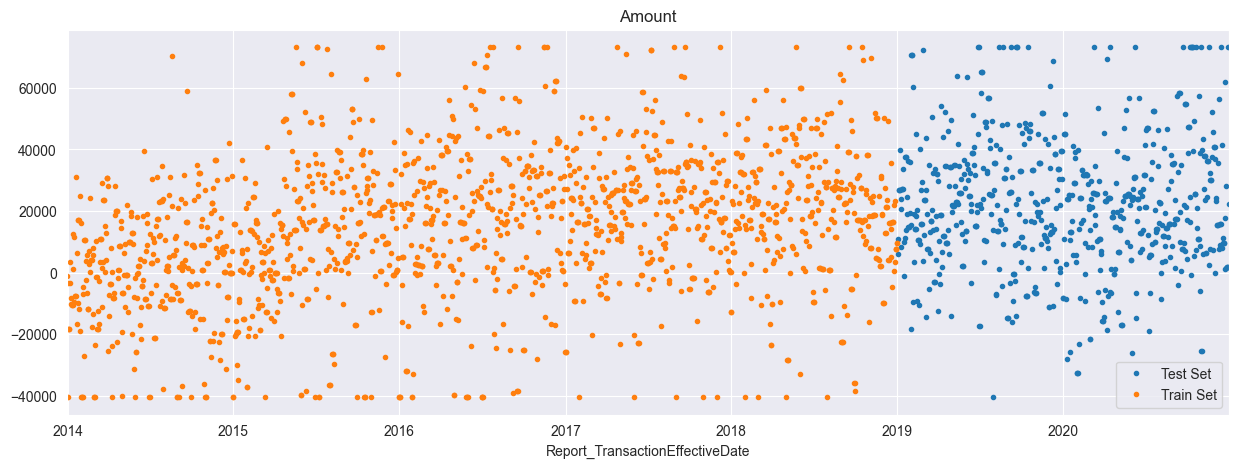

In [1074]:
split_date = '1-Jan-2019'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

data_test.rename(columns={'TransactionAmount': 'Test Set'}).join(data_train.rename(columns={'TransactionAmount': 'Train Set'}), how='outer').plot(figsize=(15, 5), title="Amount", style='.')
plt.show()

In [1075]:
shift = abs(data_train['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_train['TransactionAmount_shifted'] = data_train['TransactionAmount'] + shift  # Shift data
data_train['TransactionAmount_log'] = np.log1p(data_train['TransactionAmount_shifted'])  # Apply log

shift = abs(data_test['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_test['TransactionAmount_shifted'] = data_test['TransactionAmount'] + shift  # Shift data
data_test['TransactionAmount_log'] = np.log1p(data_test['TransactionAmount_shifted'])  # Apply log

In [1076]:
data_train_prophet = data_train.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_train_prophet

,ds,TransactionAmount,TransactionAmount_shifted,y
0,2013-12-30,-1076.913729,39341.466845,10.580060
1,2013-12-31,-40417.380574,1.000000,0.693147
2,2014-01-01,-3465.890925,36952.489649,10.517415
3,2014-01-02,-40417.380574,1.000000,0.693147
4,2014-01-03,-18386.381900,22031.998674,10.000297
...,...,...,...,...
1824,2018-12-28,7577.044740,47995.425314,10.778882
1825,2018-12-29,7577.044740,47995.425314,10.778882
1826,2018-12-30,7577.044740,47995.425314,10.778882
1827,2018-12-31,9481.245786,49899.626360,10.817789


In [1077]:
%%time
model = Prophet(
    seasonality_prior_scale=1,
    yearly_seasonality=10,
    weekly_seasonality=5,
    daily_seasonality=False,
    changepoint_prior_scale=0.0007,
    changepoint_range=0.9,
    seasonality_mode='multiplicative',
    interval_width=0.95,
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=5, prior_scale=1)
model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=1)
model.add_seasonality(name='yearly', period=365.25, fourier_order=10, prior_scale=1)

model.fit(data_train_prophet)

13:38:07 - cmdstanpy - INFO - Chain [1] start processing
13:38:08 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 500 ms
Wall time: 775 ms


In [1078]:
data_test_prophet = data_test.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_test_predict = model.predict(data_test_prophet)
data_test_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-01-02,10.715253,5.592789,12.153212,10.715253,10.715253,-0.120627,-0.120627,-0.120627,-0.177288,...,-0.004572,-0.004572,-0.004572,-0.052090,-0.052090,-0.052090,0.0,0.0,0.0,8.815568
1,2019-01-03,10.715434,5.566444,12.434542,10.715434,10.715434,-0.100718,-0.100718,-0.100718,-0.152948,...,-0.001895,-0.001895,-0.001895,-0.050335,-0.050335,-0.050335,0.0,0.0,0.0,9.076529
2,2019-01-04,10.715615,5.906956,12.889868,10.715615,10.715615,-0.061870,-0.061870,-0.061870,-0.122764,...,-0.012892,-0.012892,-0.012892,-0.048002,-0.048002,-0.048002,0.0,0.0,0.0,9.400119
3,2019-01-05,10.715797,6.310222,13.164429,10.715797,10.715797,-0.022956,-0.022956,-0.022956,-0.078786,...,-0.010654,-0.010654,-0.010654,-0.045175,-0.045175,-0.045175,0.0,0.0,0.0,9.871546
4,2019-01-06,10.715978,6.909472,13.524292,10.715978,10.715978,0.002501,0.002501,0.002501,-0.047043,...,-0.007592,-0.007592,-0.007592,-0.041951,-0.041951,-0.041951,0.0,0.0,0.0,10.211869


In [1079]:
data_test_predict['yhat_original'] = np.exp(data_test_predict['yhat']) - shift
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2019-01-02,10.715253,5.592789,12.153212,10.715253,10.715253,-0.120627,-0.120627,-0.120627,-0.177288,...,-0.004572,-0.004572,-0.052090,-0.052090,-0.052090,0.0,0.0,0.0,8.815568,-33680.046507
1,2019-01-03,10.715434,5.566444,12.434542,10.715434,10.715434,-0.100718,-0.100718,-0.100718,-0.152948,...,-0.001895,-0.001895,-0.050335,-0.050335,-0.050335,0.0,0.0,0.0,9.076529,-31670.833282
2,2019-01-04,10.715615,5.906956,12.889868,10.715615,10.715615,-0.061870,-0.061870,-0.061870,-0.122764,...,-0.012892,-0.012892,-0.048002,-0.048002,-0.048002,0.0,0.0,0.0,9.400119,-28328.557677
3,2019-01-05,10.715797,6.310222,13.164429,10.715797,10.715797,-0.022956,-0.022956,-0.022956,-0.078786,...,-0.010654,-0.010654,-0.045175,-0.045175,-0.045175,0.0,0.0,0.0,9.871546,-21047.119174
4,2019-01-06,10.715978,6.909472,13.524292,10.715978,10.715978,0.002501,0.002501,0.002501,-0.047043,...,-0.007592,-0.007592,-0.041951,-0.041951,-0.041951,0.0,0.0,0.0,10.211869,-13193.967144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,10.846711,7.210560,13.760459,10.846659,10.846763,0.028994,0.028994,0.028994,-0.027575,...,-0.007592,-0.007592,-0.048978,-0.048978,-0.048978,0.0,0.0,0.0,10.547609,-2332.127564
726,2020-12-28,10.846892,7.587183,14.136524,10.846840,10.846944,0.031657,0.031657,0.031657,0.014192,...,0.033793,0.033793,-0.051258,-0.051258,-0.051258,0.0,0.0,0.0,11.000829,19505.447308
727,2020-12-29,10.847074,7.198983,14.149490,10.847021,10.847126,0.030902,0.030902,0.030902,-0.018056,...,0.003812,0.003812,-0.052770,-0.052770,-0.052770,0.0,0.0,0.0,10.651215,1825.509297
728,2020-12-30,10.847255,7.098197,13.882686,10.847203,10.847307,0.014300,0.014300,0.014300,-0.043779,...,-0.004572,-0.004572,-0.053507,-0.053507,-0.053507,0.0,0.0,0.0,10.372378,-8453.987872


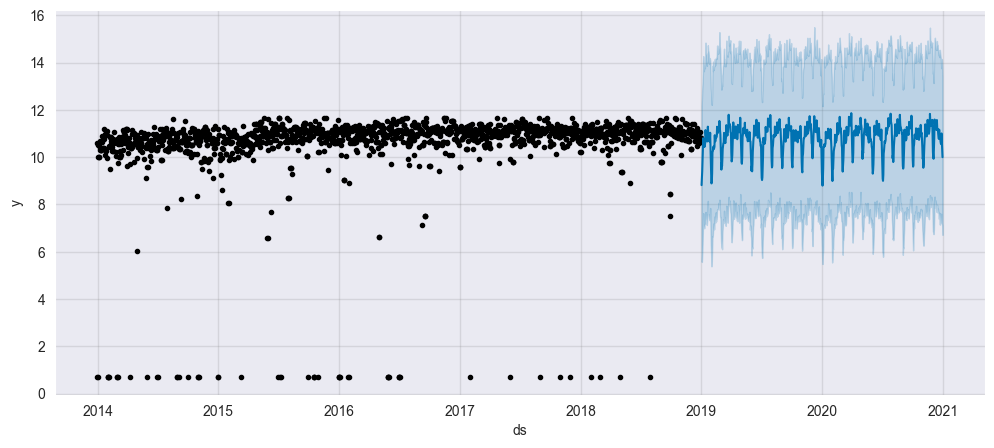

In [1080]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(data_test_predict, ax=ax)
plt.show()

In [1081]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


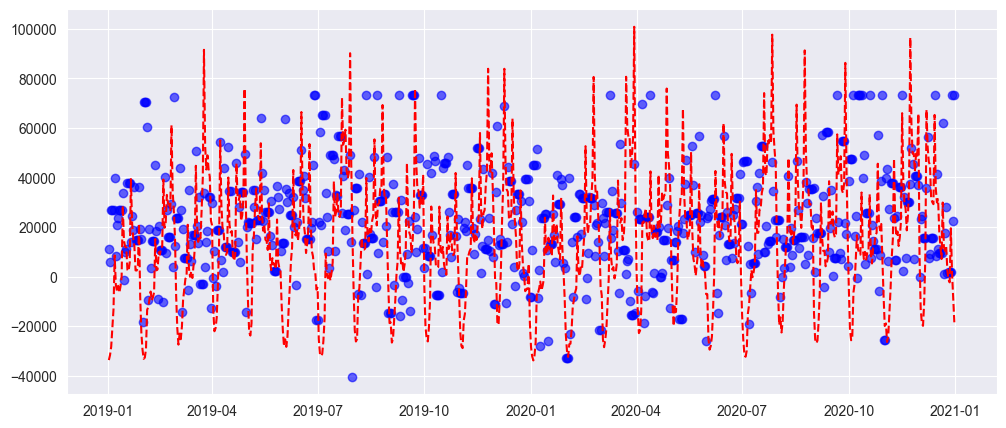

In [1082]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(data_test.index, data_test_predict["yhat_original"], color='red', linestyle='dashed', label="Predicted")
plt.show()

In [1083]:
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2019-01-02,10.715253,5.592789,12.153212,10.715253,10.715253,-0.120627,-0.120627,-0.120627,-0.177288,...,-0.004572,-0.004572,-0.052090,-0.052090,-0.052090,0.0,0.0,0.0,8.815568,-33680.046507
1,2019-01-03,10.715434,5.566444,12.434542,10.715434,10.715434,-0.100718,-0.100718,-0.100718,-0.152948,...,-0.001895,-0.001895,-0.050335,-0.050335,-0.050335,0.0,0.0,0.0,9.076529,-31670.833282
2,2019-01-04,10.715615,5.906956,12.889868,10.715615,10.715615,-0.061870,-0.061870,-0.061870,-0.122764,...,-0.012892,-0.012892,-0.048002,-0.048002,-0.048002,0.0,0.0,0.0,9.400119,-28328.557677
3,2019-01-05,10.715797,6.310222,13.164429,10.715797,10.715797,-0.022956,-0.022956,-0.022956,-0.078786,...,-0.010654,-0.010654,-0.045175,-0.045175,-0.045175,0.0,0.0,0.0,9.871546,-21047.119174
4,2019-01-06,10.715978,6.909472,13.524292,10.715978,10.715978,0.002501,0.002501,0.002501,-0.047043,...,-0.007592,-0.007592,-0.041951,-0.041951,-0.041951,0.0,0.0,0.0,10.211869,-13193.967144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,10.846711,7.210560,13.760459,10.846659,10.846763,0.028994,0.028994,0.028994,-0.027575,...,-0.007592,-0.007592,-0.048978,-0.048978,-0.048978,0.0,0.0,0.0,10.547609,-2332.127564
726,2020-12-28,10.846892,7.587183,14.136524,10.846840,10.846944,0.031657,0.031657,0.031657,0.014192,...,0.033793,0.033793,-0.051258,-0.051258,-0.051258,0.0,0.0,0.0,11.000829,19505.447308
727,2020-12-29,10.847074,7.198983,14.149490,10.847021,10.847126,0.030902,0.030902,0.030902,-0.018056,...,0.003812,0.003812,-0.052770,-0.052770,-0.052770,0.0,0.0,0.0,10.651215,1825.509297
728,2020-12-30,10.847255,7.098197,13.882686,10.847203,10.847307,0.014300,0.014300,0.014300,-0.043779,...,-0.004572,-0.004572,-0.053507,-0.053507,-0.053507,0.0,0.0,0.0,10.372378,-8453.987872


In [1084]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


In [1085]:
np.sqrt(mean_squared_error(y_true=data_test["TransactionAmount"], y_pred = data_test_predict["yhat_original"]))

31435.918713012652

In [1086]:
mean_absolute_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

24258.005190904943

In [1087]:
mean_absolute_percentage_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

243.0378316573903

In [1088]:
last_date_in_test = data_test.index[-1]
last_date_in_test

Timestamp('2020-12-31 00:00:00')

In [1089]:
future = pd.date_range(start=last_date_in_test + pd.Timedelta(days=1), periods=90, freq='D')
future_df = pd.DataFrame({'ds': future}) 

forecast_future = model.predict(future_df)
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-01-01,10.847617,5.946146,12.549434,10.847617,10.847617,-0.070953,-0.070953,-0.070953,-0.136572,...,-0.012892,-0.012892,-0.012892,-0.052726,-0.052726,-0.052726,0.0,0.0,0.0,9.366141
1,2021-01-02,10.847799,5.991150,12.589422,10.847799,10.847799,-0.109472,-0.109472,-0.109472,-0.171416,...,-0.010654,-0.010654,-0.010654,-0.051290,-0.051290,-0.051290,0.0,0.0,0.0,8.988310
2,2021-01-03,10.847980,5.622022,12.278238,10.847980,10.847980,-0.120627,-0.120627,-0.120627,-0.177455,...,-0.007592,-0.007592,-0.007592,-0.049236,-0.049236,-0.049236,0.0,0.0,0.0,8.922955
3,2021-01-04,10.848161,6.275394,12.971105,10.848161,10.848161,-0.100718,-0.100718,-0.100718,-0.113569,...,0.033793,0.033793,0.033793,-0.046645,-0.046645,-0.046645,0.0,0.0,0.0,9.616142
4,2021-01-05,10.848343,6.494543,12.991289,10.848343,10.848343,-0.061870,-0.061870,-0.061870,-0.101665,...,0.003812,0.003812,0.003812,-0.043607,-0.043607,-0.043607,0.0,0.0,0.0,9.745445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,10.863030,7.906147,14.669427,10.863027,10.863032,0.034849,0.034849,0.034849,0.057091,...,-0.010654,-0.010654,-0.010654,0.032896,0.032896,0.032896,0.0,0.0,0.0,11.483207
86,2021-03-28,10.863211,8.161007,14.735340,10.863209,10.863214,0.029473,0.029473,0.029473,0.057429,...,-0.007592,-0.007592,-0.007592,0.035548,0.035548,0.035548,0.0,0.0,0.0,11.487077
87,2021-03-29,10.863392,8.705403,15.390163,10.863390,10.863395,0.030006,0.030006,0.030006,0.101399,...,0.033793,0.033793,0.033793,0.037601,0.037601,0.037601,0.0,0.0,0.0,11.964935
88,2021-03-30,10.863574,8.335726,15.392185,10.863571,10.863576,0.032525,0.032525,0.032525,0.075343,...,0.003812,0.003812,0.003812,0.039006,0.039006,0.039006,0.0,0.0,0.0,11.682065


In [1090]:
forecast_future['yhat_original'] = np.exp(forecast_future['yhat']) - shift
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2021-01-01,10.847617,5.946146,12.549434,10.847617,10.847617,-0.070953,-0.070953,-0.070953,-0.136572,...,-0.012892,-0.012892,-0.052726,-0.052726,-0.052726,0.0,0.0,0.0,9.366141,-28732.445914
1,2021-01-02,10.847799,5.991150,12.589422,10.847799,10.847799,-0.109472,-0.109472,-0.109472,-0.171416,...,-0.010654,-0.010654,-0.051290,-0.051290,-0.051290,0.0,0.0,0.0,8.988310,-32409.471671
2,2021-01-03,10.847980,5.622022,12.278238,10.847980,10.847980,-0.120627,-0.120627,-0.120627,-0.177455,...,-0.007592,-0.007592,-0.049236,-0.049236,-0.049236,0.0,0.0,0.0,8.922955,-32916.154547
3,2021-01-04,10.848161,6.275394,12.971105,10.848161,10.848161,-0.100718,-0.100718,-0.100718,-0.113569,...,0.033793,0.033793,-0.046645,-0.046645,-0.046645,0.0,0.0,0.0,9.616142,-25413.333879
4,2021-01-05,10.848343,6.494543,12.991289,10.848343,10.848343,-0.061870,-0.061870,-0.061870,-0.101665,...,0.003812,0.003812,-0.043607,-0.043607,-0.043607,0.0,0.0,0.0,9.745445,-23342.110679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,10.863030,7.906147,14.669427,10.863027,10.863032,0.034849,0.034849,0.034849,0.057091,...,-0.010654,-0.010654,0.032896,0.032896,0.032896,0.0,0.0,0.0,11.483207,56653.484954
86,2021-03-28,10.863211,8.161007,14.735340,10.863209,10.863214,0.029473,0.029473,0.029473,0.057429,...,-0.007592,-0.007592,0.035548,0.035548,0.035548,0.0,0.0,0.0,11.487077,57029.932554
87,2021-03-29,10.863392,8.705403,15.390163,10.863390,10.863395,0.030006,0.030006,0.030006,0.101399,...,0.033793,0.033793,0.037601,0.037601,0.037601,0.0,0.0,0.0,11.964935,116728.305235
88,2021-03-30,10.863574,8.335726,15.392185,10.863571,10.863576,0.032525,0.032525,0.032525,0.075343,...,0.003812,0.003812,0.039006,0.039006,0.039006,0.0,0.0,0.0,11.682065,78010.181784


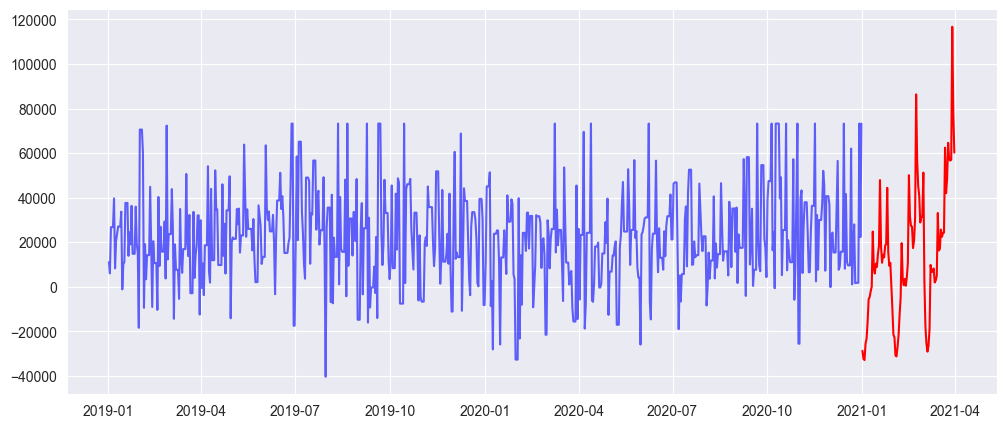

In [1091]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(forecast_future['ds'], forecast_future["yhat_original"], color='red', label="Predicted")
plt.show()

In [1092]:
export_df = pd.DataFrame({
    'GroupName': 'Precision Analyst',
    'Date': forecast_future['ds'].dt.date,
    'TotalPredictedAmount': forecast_future['yhat_original']
})

# Round the predicted amounts to 2 decimal places
export_df['TotalPredictedAmount'] = export_df['TotalPredictedAmount'].round(2)

# Export to Excel
export_df.to_excel('forecast_results_prophet_2.xlsx', index=False)

# Display the first few rows of the exported data
print("Preview of exported data:")
print(export_df.head())

Preview of exported data:
           GroupName        Date  TotalPredictedAmount
0  Precision Analyst  2021-01-01             -28732.45
1  Precision Analyst  2021-01-02             -32409.47
2  Precision Analyst  2021-01-03             -32916.15
3  Precision Analyst  2021-01-04             -25413.33
4  Precision Analyst  2021-01-05             -23342.11
